In [1]:
#Work in Progress (Masks are missing some objects in masks)
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
from tqdm import tqdm

In [6]:
train_path='../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train'
val_path='../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val'

In [7]:
train_images=[]
train_masks=[]
val_images=[]
val_masks=[]
def load_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.jpg'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=i[:,:256]
        msk=i[:,256:]  
        temp_img.append(img)
        temp_mask.append(msk)
    return temp_img,temp_mask

train_images,train_masks=load_images(train_path)
val_images,val_masks=load_images(val_path)

100%|██████████| 500/500 [00:01<00:00, 281.26it/s]


In [4]:
def lrelu(x,threshold=0.1):
    return tf.maximum(x,x*threshold)

def conv_layer(x,n_filters,k_size,stride,padding='SAME'):
    x=tf.layers.conv2d(x,filters=n_filters,kernel_size=k_size,strides=stride,padding=padding)
    x=tf.nn.relu(x)
    return x

def max_pool(x,pool_size):
    x=tf.layers.max_pooling2d(x,pool_size=pool_size)
    return x

def conv_transpose(x,n_filters,k_size,stride,padding='SAME'):
    x=tf.layers.conv2d_transpose(x,filters=n_filters,kernel_size=k_size,strides=stride,padding=padding)
    x=tf.nn.relu(x)
    return x


#Placeholders
image=tf.placeholder(tf.float32,[None,256,256,3],name='Input_image')
mask=tf.placeholder(tf.float32,[None,256,256,3],name='Image_mask')


#########################Beta Network

#Branch-1
layer_1=conv_layer(image,n_filters=64,k_size=4,stride=1)
mp_1=tf.layers.max_pooling2d(layer_1,pool_size=2,strides=2)

layer_2=conv_layer(mp_1,n_filters=128,k_size=4,stride=1)
mp_2=tf.layers.max_pooling2d(layer_2,pool_size=2,strides=2)

layer_3=conv_layer(mp_2,n_filters=256,k_size=4,stride=1)
mp_3=tf.layers.max_pooling2d(layer_3,pool_size=2,strides=2)

layer_4=conv_layer(mp_3,n_filters=512,k_size=4,stride=1)
mp_4=tf.layers.max_pooling2d(layer_4,pool_size=2,strides=2)

layer_5=conv_layer(mp_4,n_filters=1024,k_size=4,stride=1)
mp_5=tf.layers.max_pooling2d(layer_5,pool_size=2,strides=2)


#Branch_2
layer_b1=conv_layer(image,n_filters=128,k_size=4,stride=1)
mp_b1=tf.layers.max_pooling2d(layer_b1,pool_size=2,strides=2)

beta_1=tf.keras.layers.add([layer_2,mp_b1])

layer_b2=conv_layer(beta_1,n_filters=256,k_size=4,stride=1)
mp_b2=tf.layers.max_pooling2d(layer_b2,pool_size=2,strides=2)

beta_2=tf.keras.layers.add([layer_3,mp_b2])

layer_b3=conv_layer(beta_2,n_filters=512,k_size=4,stride=1)
mp_b3=tf.layers.max_pooling2d(layer_b3,pool_size=2,strides=2)

beta_3=tf.keras.layers.add([mp_b3,layer_4])

layer_b4=conv_layer(beta_3,n_filters=1024,k_size=4,stride=1)
mp_b4=tf.layers.max_pooling2d(layer_b4,pool_size=2,strides=2)

beta_4=tf.keras.layers.add([mp_b4,layer_5])

beta_0=layer_1
########################################################




#Downsample
#64
x_layer_1=conv_layer(image,n_filters=64,k_size=4,stride=1)
x_layer_1=conv_layer(x_layer_1,n_filters=64,k_size=4,stride=1)
x_layer_1=conv_layer(x_layer_1,n_filters=64,k_size=4,stride=2)
x_batch_1=tf.layers.batch_normalization(x_layer_1)#128x128x64

#128
x_layer_2=conv_layer(x_batch_1,n_filters=128,k_size=4,stride=1)
x_layer_2=conv_layer(x_layer_2,n_filters=128,k_size=4,stride=1)
x_layer_2=conv_layer(x_layer_2,n_filters=128,k_size=4,stride=2)
x_batch_2=tf.layers.batch_normalization(x_layer_2)#64x64x128

#256
x_layer_3=conv_layer(x_batch_2,n_filters=256,k_size=4,stride=1)
x_layer_3=conv_layer(x_layer_3,n_filters=256,k_size=4,stride=1)
x_layer_3=conv_layer(x_layer_3,n_filters=256,k_size=4,stride=2)
x_batch_3=tf.layers.batch_normalization(x_layer_3)#32x32x256

#512
x_layer_4=conv_layer(x_batch_3,n_filters=512,k_size=4,stride=1)
x_layer_4=conv_layer(x_layer_4,n_filters=512,k_size=4,stride=2)
x_batch_4=tf.layers.batch_normalization(x_layer_4)#16x16x512

#1024
x_layer_5=conv_layer(x_batch_4,n_filters=1024,k_size=4,stride=1)
x_layer_5=conv_layer(x_layer_5,n_filters=1024,k_size=4,stride=4)
x_batch_5=tf.layers.batch_normalization(x_layer_5)#4x4x1024


#Upsample
#1024
y_layer_1=conv_transpose(x_batch_5,n_filters=1024,k_size=4,stride=4)
y_layer_1=tf.keras.layers.add([y_layer_1,beta_4])
y_layer_1=conv_layer(y_layer_1,n_filters=1024,k_size=4,stride=1)
y_batch_1=tf.layers.batch_normalization(y_layer_1)


#512
y_layer_2=conv_transpose(y_batch_1,n_filters=512,k_size=4,stride=2)
y_layer_2=tf.keras.layers.add([y_layer_2,beta_3])
y_layer_2=conv_layer(y_layer_2,n_filters=512,k_size=4,stride=1)
y_batch_2=tf.layers.batch_normalization(y_layer_2)

#256
y_layer_3=conv_transpose(y_batch_2,n_filters=256,k_size=4,stride=2)
y_layer_3=tf.keras.layers.add([y_layer_3,beta_2])
y_layer_3=conv_layer(y_layer_3,n_filters=256,k_size=4,stride=1)
y_layer_3=conv_layer(y_layer_3,n_filters=256,k_size=4,stride=1)
y_batch_3=tf.layers.batch_normalization(y_layer_3)


#128
y_layer_4=conv_transpose(y_batch_3,n_filters=128,k_size=4,stride=2)
y_layer_4=tf.keras.layers.add([y_layer_4,beta_1])
y_layer_4=conv_layer(y_layer_4,n_filters=128,k_size=4,stride=1)
y_layer_4=conv_layer(y_layer_4,n_filters=128,k_size=4,stride=1)
y_batch_4=tf.layers.batch_normalization(y_layer_4)

#64
y_layer_5=conv_transpose(y_batch_4,n_filters=64,k_size=4,stride=2)
y_layer_5=tf.keras.layers.add([y_layer_5,beta_0])
y_layer_5=conv_layer(y_layer_5,n_filters=64,k_size=4,stride=1)
y_layer_5=conv_layer(y_layer_5,n_filters=64,k_size=4,stride=1)
y_batch_5=tf.layers.batch_normalization(y_layer_5)

#Output
out=tf.layers.conv2d(y_batch_5,activation=None,filters=3,kernel_size=3,strides=1,padding='SAME')


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [ ]:
loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=mask,logits=out))
train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

In [ ]:

num_epochs=100
batch_size=25
train_batches=len(train_images)//batch_size
val_batches=len(val_images)//batch_size
train_loss,val_loss=[],[]
saver=tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        print('======================================')
        print('Epoch: ',(epoch+1))
        print('In Training..')
        for batch in tqdm(range(train_batches)):
            train_img_batch=train_images[batch*batch_size:(batch+1)*batch_size]
            train_msk_batch=train_masks[batch*batch_size:(batch+1)*batch_size]
            #reshape images and masks
            train_img_batch=np.reshape(train_img_batch,(len(train_img_batch),256,256,3))
            train_msk_batch=np.reshape(train_msk_batch,(len(train_msk_batch),256,256,3))
            t_loss,_=sess.run([loss,train_op],feed_dict={
                    image:train_img_batch,mask:train_msk_batch})
            
        print('In Validation..')
        for v_batch in tqdm(range(val_batches)):
            val_img_batch=val_images[v_batch*batch_size:(v_batch+1)*batch_size]
            val_msk_batch=val_masks[v_batch*batch_size:(v_batch+1)*batch_size]
            
            #Reshape batches
            val_img_batch=np.reshape(val_img_batch,(len(val_img_batch),256,256,3))
            val_msk_batch=np.reshape(val_msk_batch,(len(val_msk_batch),256,256,3))
            v_loss,_=sess.run([loss,train_op],feed_dict={image:val_img_batch,mask:val_msk_batch})
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        
        print('Train Loss: ',t_loss)
        print('Val Loss: ',v_loss)
    saver.save(sess, "model.ckpt")

INFO:tensorflow:Restoring parameters from ../input/semanttc-segmentation-code/model.ckpt
Model Restored!


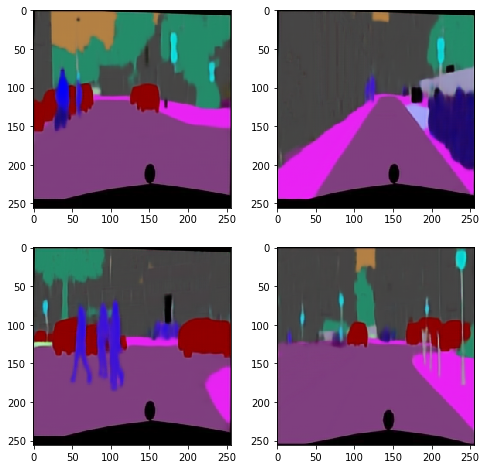

In [9]:
saver=tf.train.Saver()
img_=train_images[5:10]
msk_=train_masks[5:10]
preds=[]
w,h=256,256
col,row=2,2
ckpt_path='../input/semanttc-segmentation-code/model.ckpt'
with tf.Session() as sess_1:
    saver.restore(sess_1,ckpt_path)
    print('Model Restored!')
    seg=sess_1.run(out,feed_dict={image:img_})
    seg=sess_1.run(tf.nn.sigmoid(seg))
    fig=plt.figure(figsize=(8,8))
    for i in range(1,row*col+1):
        fig.add_subplot(row,col,i)
        plt.imshow(seg[i-1])
    plt.show()